<center>
<img src="Stone_Soup_Icon_Final_small.png">
<h1>Stone Soup Run Manager Demo 01 - Basic</h1>
Demonstrating the capabilities of the Stone Soup Run Manager to run batches of experiments.
</center>

Generating Data
----------------
First we'll create some models, which will be used to generate data.

This will include a 2D-position constant velocity transition model ($x$, $\dot{x}$, $y$ and $\dot{y}$) generated by combining two 1D models (this allows multiple models to be mixed and generation of *n*-dimension models).

In [1]:
import numpy as np
import datetime
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity

transition_model = CombinedLinearGaussianTransitionModel((ConstantVelocity(1), ConstantVelocity(1)))

And a measurement model, which will map the position based detections ($x$ and $y$) to the position in the state.

In [2]:
from stonesoup.models.measurement.linear import LinearGaussian

measurement_model = LinearGaussian(ndim_state=4, mapping=[0, 2], noise_covar=np.diag([10, 10]))

Next we'll create a multi-target ground truth simulation in order to generate some data for testing the tracking algorithms. This utilises the *transition model* to generate the ground truth paths, initialised at random by sampling from a *Gaussian State*. A ground truth track/path at each timestamp is created at a random *birth rate* ($\lambda$ in Poisson distribution), and randomly killed by a *death probability*.

In [3]:
from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
from stonesoup.types.state import GaussianState
from stonesoup.types.array import StateVector, CovarianceMatrix

groundtruth_sim = MultiTargetGroundTruthSimulator(
    transition_model=transition_model,
    initial_state=GaussianState(
        StateVector([[0], [0], [0], [0]]),
        CovarianceMatrix(np.diag([1000000, 10, 1000000, 10]))),
    timestep=datetime.timedelta(seconds=5),
    birth_rate=0.3,
    death_probability=0.05
)

Next we'll create a detection simulator which will generate detections based on a *detection probability* about the ground truth, utilising the *measurement model*. This model will also create clutter in our defined *measurement range*.

In [4]:
from stonesoup.simulator.simple import SimpleDetectionSimulator

detection_sim = SimpleDetectionSimulator(
    groundtruth=groundtruth_sim,
    measurement_model=measurement_model,
    meas_range=np.array([[-1, 1], [-1, 1]])*5000,  # Area to generate clutter
    detection_probability=0.9,
    clutter_rate=3,
)

Building Kalman tracker components
------------------------------------

With the detection data ready, we'll now build a Kalman tracker. For this we will need a Kalman predictor, which will utilise the same *transition model* we used in the ground truth simulator.

In [5]:
from stonesoup.predictor.kalman import KalmanPredictor

predictor = KalmanPredictor(transition_model)

And a Kalman updater, utilising the same *measurement model* we used in the detection simulator.

In [6]:
from stonesoup.updater.kalman import KalmanUpdater

updater = KalmanUpdater(measurement_model)

We will also need a data associator to link detections to the "correct" track for the update step: in this case a Nearest Neighbour is fine for this demo. The data associator requires a hypothesiser which calculates some form of score/probability of each track being associated to each detection: in this case using a Mahalanobis distance from track prediction to the detection (which will also generate missed detection hypothesis).

In [7]:
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis

hypothesiser = DistanceHypothesiser(predictor, updater, Mahalanobis(), missed_distance=3)

In [8]:
from stonesoup.dataassociator.neighbour import NearestNeighbour

data_associator = NearestNeighbour(hypothesiser)

And finally a initiator to generate tracks from unassociated detections, in this case a single point initiator generating a track for every unassociated detection.

In [9]:
from stonesoup.initiator.simple import SinglePointInitiator

initiator = SinglePointInitiator(
    GaussianState(np.array([[0], [0], [0], [0]]), np.diag([10000, 100, 10000, 1000])),
    measurement_model=measurement_model)

And a deleter to remove tracks, for this demo simply based on large covariance threshold.

In [10]:
from stonesoup.deleter.error import CovarianceBasedDeleter

deleter = CovarianceBasedDeleter(covar_trace_thresh=1E3)

With all the components in place, we'll now construct the tracker with a multi target tracker.

In [11]:
from stonesoup.tracker.simple import MultiTargetTracker

tracker = MultiTargetTracker(
    initiator=initiator,
    deleter=deleter,
    detector=detection_sim,
    data_associator=data_associator,
    updater=updater,
)

Creating the Metrics package
----------------------------
We now construct the Metrics package that will be run against the output of the multi target tracker, encoded in the format that the Run Manager understands.

In [12]:
from stonesoup.metricgenerator.basicmetrics import BasicMetrics
from stonesoup.metricgenerator.ospametric import OSPAMetric
from stonesoup.metricgenerator.tracktotruthmetrics import SIAPMetrics
from stonesoup.dataassociator.tracktotrack import EuclideanTrackToTruth

basic_calculator = BasicMetrics()
ospa_calculator = OSPAMetric(c=10, p=1, measurement_model_track=measurement_model,
                             measurement_model_truth=measurement_model)
siap_calculator = SIAPMetrics()

associator = EuclideanTrackToTruth(measurement_model_truth=measurement_model,
                                   measurement_model_track=measurement_model,
                                   association_threshold=30)

metrics_conditions = {'metric_01': basic_calculator, 'metric_02': ospa_calculator,
                      'metric_03': siap_calculator, 'associator':associator}

Assembling the Run Manager Experiment
-------------------------------------
We now assemble to components of the Run Manager experiment, encoded in the format that the Run Manager understands.

In [13]:
config_top_level = {}
config_top_level['tracker01'] = tracker
config_top_level['tracker02'] = tracker
config_top_level['components'] = {}
config_top_level['conditions'] = {}
config_top_level['metrics'] = metrics_conditions

Running the Run Manager Experiment
----------------------------------
We then run the experiment and output

In [14]:
from stonesoup.runmanager.manager import SimpleRunManager

local_run_manager = SimpleRunManager(run_checks=True)
local_run_manager.load_config(object=config_top_level)

local_run_manager.run_experiment(save_detections_tracks=True)
local_run_manager.output_experiment_results()

Tracker processed.
Tracker processed.


The results have been output to the following text file:

In [15]:
print(local_run_manager.experiment_results_filename)

run_manager_results\2019-06-10_23-17_experiment_results.txt


Displaying the Experiment Results
--------------------------------------
Here, we display the results of the experiment and demonstrate how users can analyze and manipulate them.

First, we read the experiment results back from the output file. We will only be using the results from the first tracker.

In [16]:
from ruamel.yaml import YAML

with open(local_run_manager.experiment_results_filename, 'r') as myfile:
    experiment_results = YAML().load(myfile.read())

In [17]:
tracks = set(experiment_results[list(experiment_results.keys())[0]]['tracks'])
groundtruth_paths = set(experiment_results[list(experiment_results.keys())[0]]['groundtruth'])
detections = set(experiment_results[list(experiment_results.keys())[0]]['detections'])

We plot the tracks, detections, and groundtruth so we can see how well they match up.

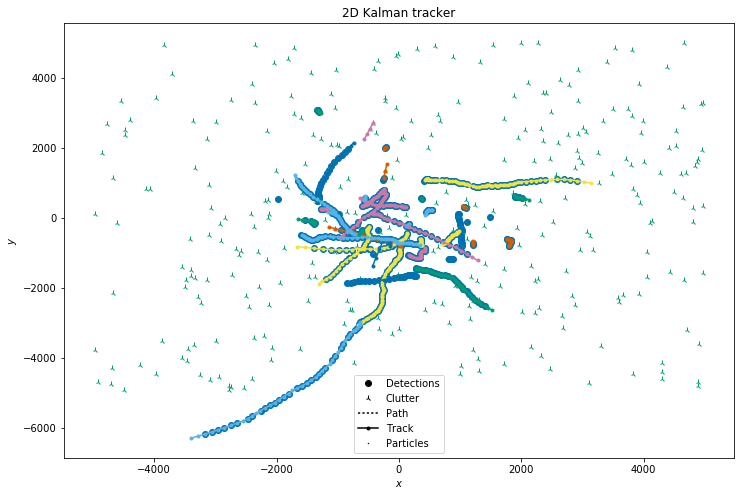

In [18]:
# Plotting
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-colorblind')

from stonesoup.metricgenerator.plotter import TwoDPlotter

plot_data = TwoDPlotter([0, 2], [0, 2], [0, 1]).plot_tracks_truth_detections
plot_data(tracks, groundtruth_paths, detections)
plt.title("2D Kalman tracker");

We also look at the metrics that were calculated.  Most of the metrics are simple values.

In [19]:
from stonesoup.types.metric import PlottingMetric

metrics_results = experiment_results[list(experiment_results.keys())[0]]['results'].values()

for metric in metrics_results:
    if metric.title not in ["OSPA distances", "Track plot"]:
        print(metric.title,":", metric.value)

Track-to-target ratio : 1.0
Number of tracks : 38
Number of targets : 38
SIAP C : 0.941747572815534
SIAP LT : -458.3333333333333
SIAP LS : 0.8568965517241379
SIAP S : 0.11280487804878049
SIAP A : 1.0


The OSPA metric is a list of the OSPA distances at each timestep.

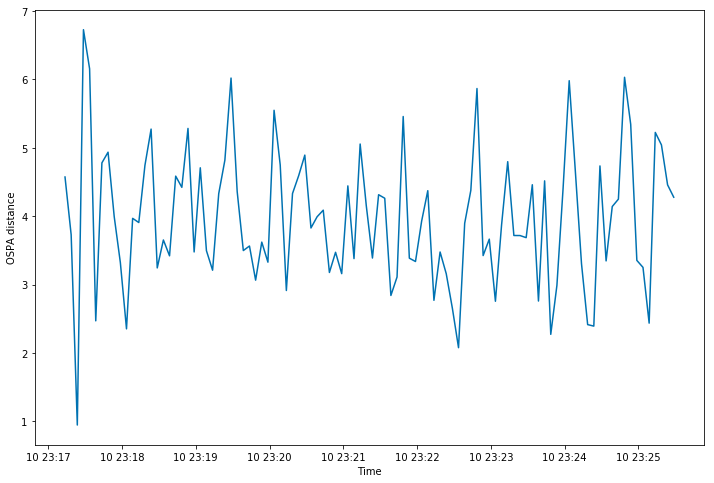

In [20]:
ospa_metric = [i for i in metrics_results if i.title == "OSPA distances"][0]

plt.figure()
plt.plot([i.timestamp for i in ospa_metric.value], [i.value for i in ospa_metric.value])
plt.ylabel("OSPA distance")
plt.xlabel("Time")
plt.show()